In [1]:
from datetime import datetime
import warnings
import os

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import RocCurveDisplay, roc_curve
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config

from get_model_training_data_05 import get_features_and_data
from get_model_training_data_05 import weighted_absolute_percentage_error as wape

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2)
sns.set_style("ticks")

set_config(transform_output="pandas")

warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

## Load Training and Testing Data

In [2]:
(df, train_df, test_df, features, next_month) = get_features_and_data()

training examples = 2256, testing examples = 251


## Model-Building and Evaluation

In [57]:
def train_model(train_df):
    ct = ColumnTransformer(remainder="passthrough",
                           transformers=[
                               ("ss", StandardScaler(), ["days_since_previous_release", "month_holidays"])])

    pipeline = Pipeline(
        [("ct", ct), ("en", ElasticNet(random_state=1024))])

    model = GridSearchCV(
        pipeline,
        param_grid={"en__alpha" : [0.00001, 0.0001, 0.001, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1, 1.5, 2],
                    "en__l1_ratio" : [0, 0.00001, 0.0001, 0.001, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]},
        scoring="neg_mean_absolute_percentage_error", cv=3, refit=True)
    
    model.fit(train_df[features], train_df["prob_of_release"])
    
    return model

In [58]:
model = train_model(train_df)

In [59]:
model.best_params_

{'en__alpha': 1e-05, 'en__l1_ratio': 0}

In [60]:
model.best_score_ * -1

0.380585598546814

In [61]:
sorted(zip(model.feature_names_in_, model.best_estimator_["en"].coef_), key=lambda x : x[1], reverse=True)

[('days_since_previous_release', 0.1693999315075126),
 ('M_Sep', 0.047758299664101125),
 ('WD_Wednesday', 0.031758631781641136),
 ('month_holidays', 0.02694784982121617),
 ('WD_Thursday', 0.026397773750834703),
 ('M_Apr', 0.02170310226541566),
 ('M_Jul', 0.019137931135429852),
 ('M_Jun', 0.01886688049185368),
 ('M_Oct', 0.014222155825156799),
 ('M_Aug', 0.005668201947650398),
 ('WD_Tuesday', 0.001362426363338238),
 ('WD_Friday', -0.004167802240879851),
 ('M_May', -0.006880393963722327),
 ('M_Jan', -0.008013255157819353),
 ('M_Nov', -0.009750689377794358),
 ('M_Dec', -0.01731770307318299),
 ('WD_Saturday', -0.037418541142288694),
 ('WD_Monday', -0.038191974929791546),
 ('M_Mar', -0.041663780804630665),
 ('WD_Sunday', -0.05055900355842313),
 ('M_Feb', -0.08434025723830339),
 ('previous_release_post', -0.2109260799906774)]

In [62]:
test_df["predicted_prob"] = model.predict(test_df[features])
test_df["predicted_prob"] = test_df["predicted_prob"].apply(lambda x : 0 if x < 0 else (1 if x > 1 else x))

In [63]:
mape(test_df["prob_of_release"], test_df["predicted_prob"])

0.32399473884322694

In [64]:
wape(test_df["prob_of_release"], test_df["predicted_prob"])

0.2572457199935601

In [65]:
test_df["residuals"] = test_df["predicted_prob"] - test_df["prob_of_release"]
# sns.scatterplot(data=test_df, x="predicted_prob", y="residuals", s=75)

In [66]:
test_df[["index", "prob_of_release", "predicted_prob", "residuals"]].sort_values(by=["residuals"])

,index,prob_of_release,predicted_prob,residuals
2507,2023-12-30,1.000000,0.394542,-0.605458
2373,2023-08-18,1.000000,0.427527,-0.572473
2352,2023-07-28,1.000000,0.464248,-0.535752
2432,2023-10-16,1.000000,0.476825,-0.523175
2457,2023-11-10,1.000000,0.481863,-0.518137
...,...,...,...,...
2343,2023-07-19,0.500000,0.757757,0.257757
2449,2023-11-02,0.250000,0.512429,0.262429
2339,2023-07-15,0.214286,0.482514,0.268228
2407,2023-09-21,0.250000,0.523434,0.273434


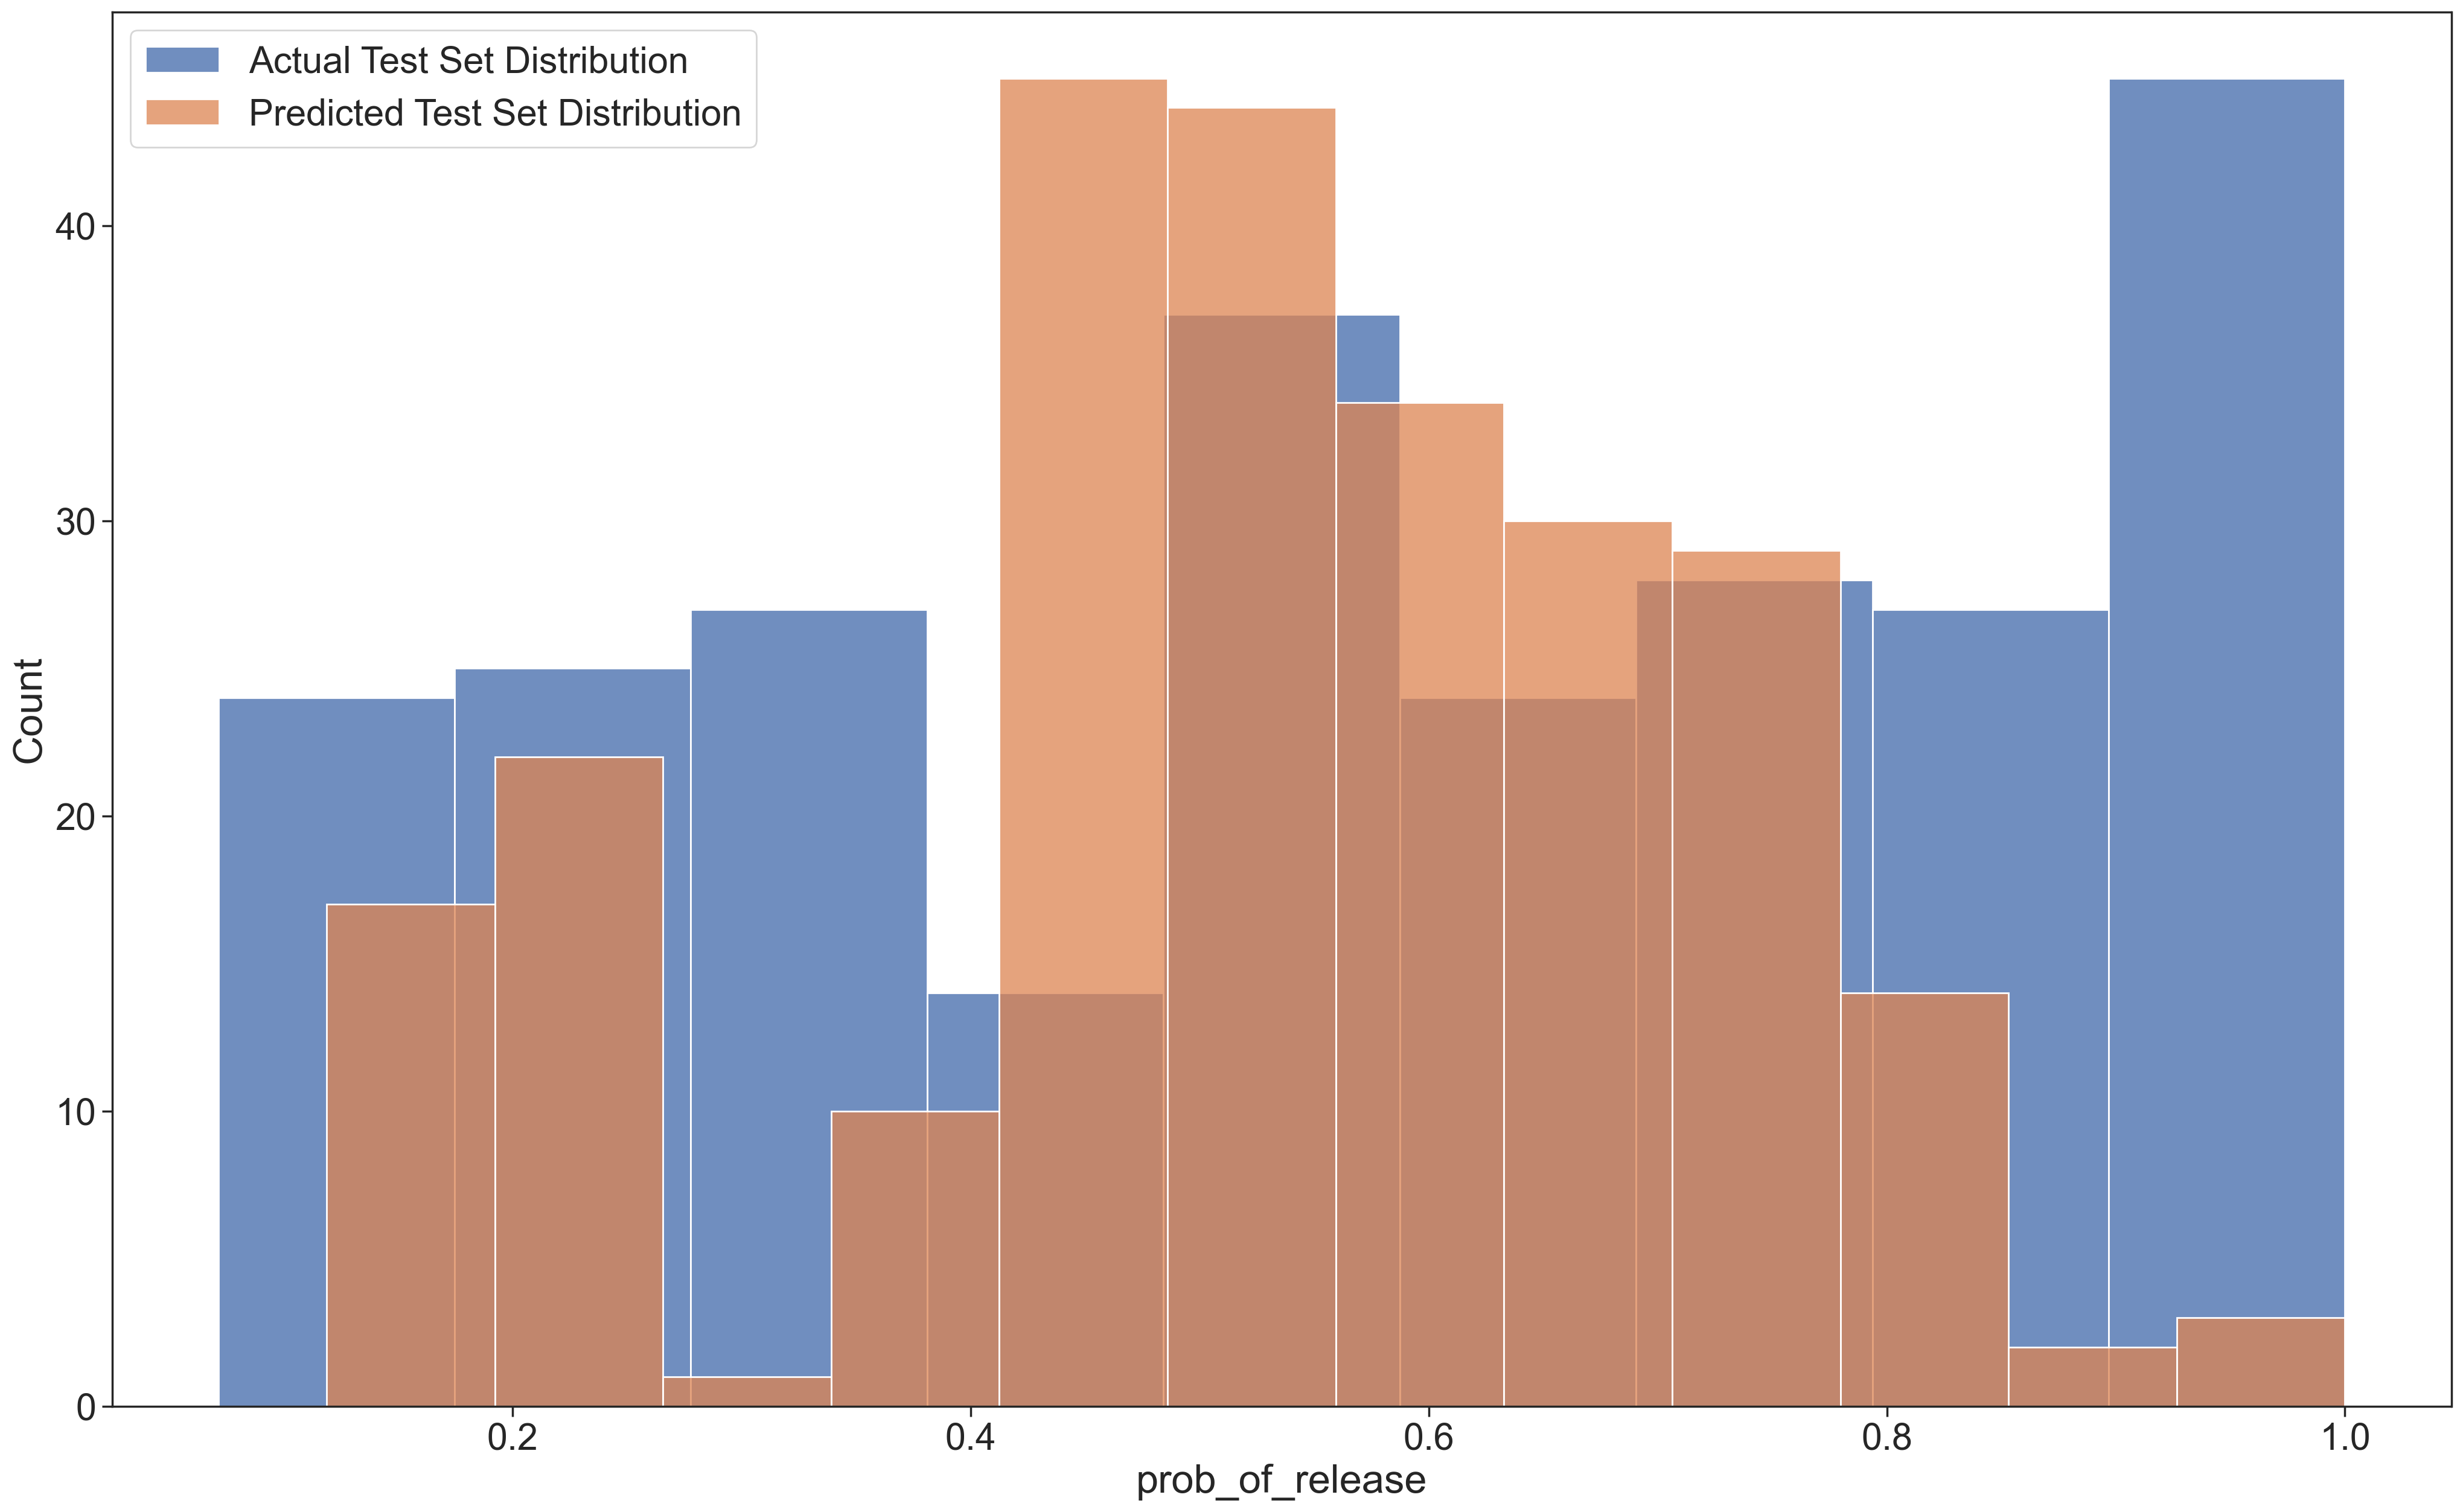

In [67]:
ax = sns.histplot(x=test_df["prob_of_release"], alpha=0.8, label="Actual Test Set Distribution")
sns.histplot(x=test_df["predicted_prob"], ax=ax, label="Predicted Test Set Distribution")
ax.legend()
plt.show()

## Predictions for the Next Month

In [68]:
model = train_model(df)

In [69]:
# based on https://machinelearningmastery.com/prediction-intervals-for-machine-learning/

preds = model.predict(df[features])
preds[preds < 0] = 0
preds[preds > 1] = 1

sum_errs = np.sum((df["prob_of_release"] - preds) ** 2)
stdev = np.sqrt(1 / (len(df["prob_of_release"]) - 2) * sum_errs)
stdev

0.1862692627505259

In [70]:
next_month["predicted_prob"] = model.predict(next_month[features])
next_month["predicted_prob"] = next_month["predicted_prob"].apply(lambda x : 0 if x < 0 else (1 if x > 1 else x))

In [71]:
next_month["predicted_min"] = next_month["predicted_prob"] - (1.96 * stdev)
next_month["predicted_min"] = next_month["predicted_min"].apply(lambda x : 0 if x < 0 else x)
next_month["predicted_max"] = next_month["predicted_prob"] + (1.96 * stdev)
next_month["predicted_max"] = next_month["predicted_max"].apply(lambda x : 1 if x > 1 else x)

In [72]:
next_month[["index", "predicted_min", "predicted_prob", "predicted_max"]]

,index,predicted_min,predicted_prob,predicted_max
1,2023-12-31,0.000000,0.128550,0.493638
2,2024-01-01,0.065140,0.430228,0.795316
3,2024-01-02,0.157044,0.522132,0.887219
4,2024-01-03,0.237574,0.602662,0.967750
5,2024-01-04,0.284485,0.649573,1.000000
6,2024-01-05,0.306622,0.671709,1.000000
7,2024-01-06,0.319235,0.684323,1.000000
8,2024-01-07,0.356164,0.721251,1.000000
9,2024-01-08,0.426194,0.791282,1.000000
10,2024-01-09,0.518098,0.883185,1.000000


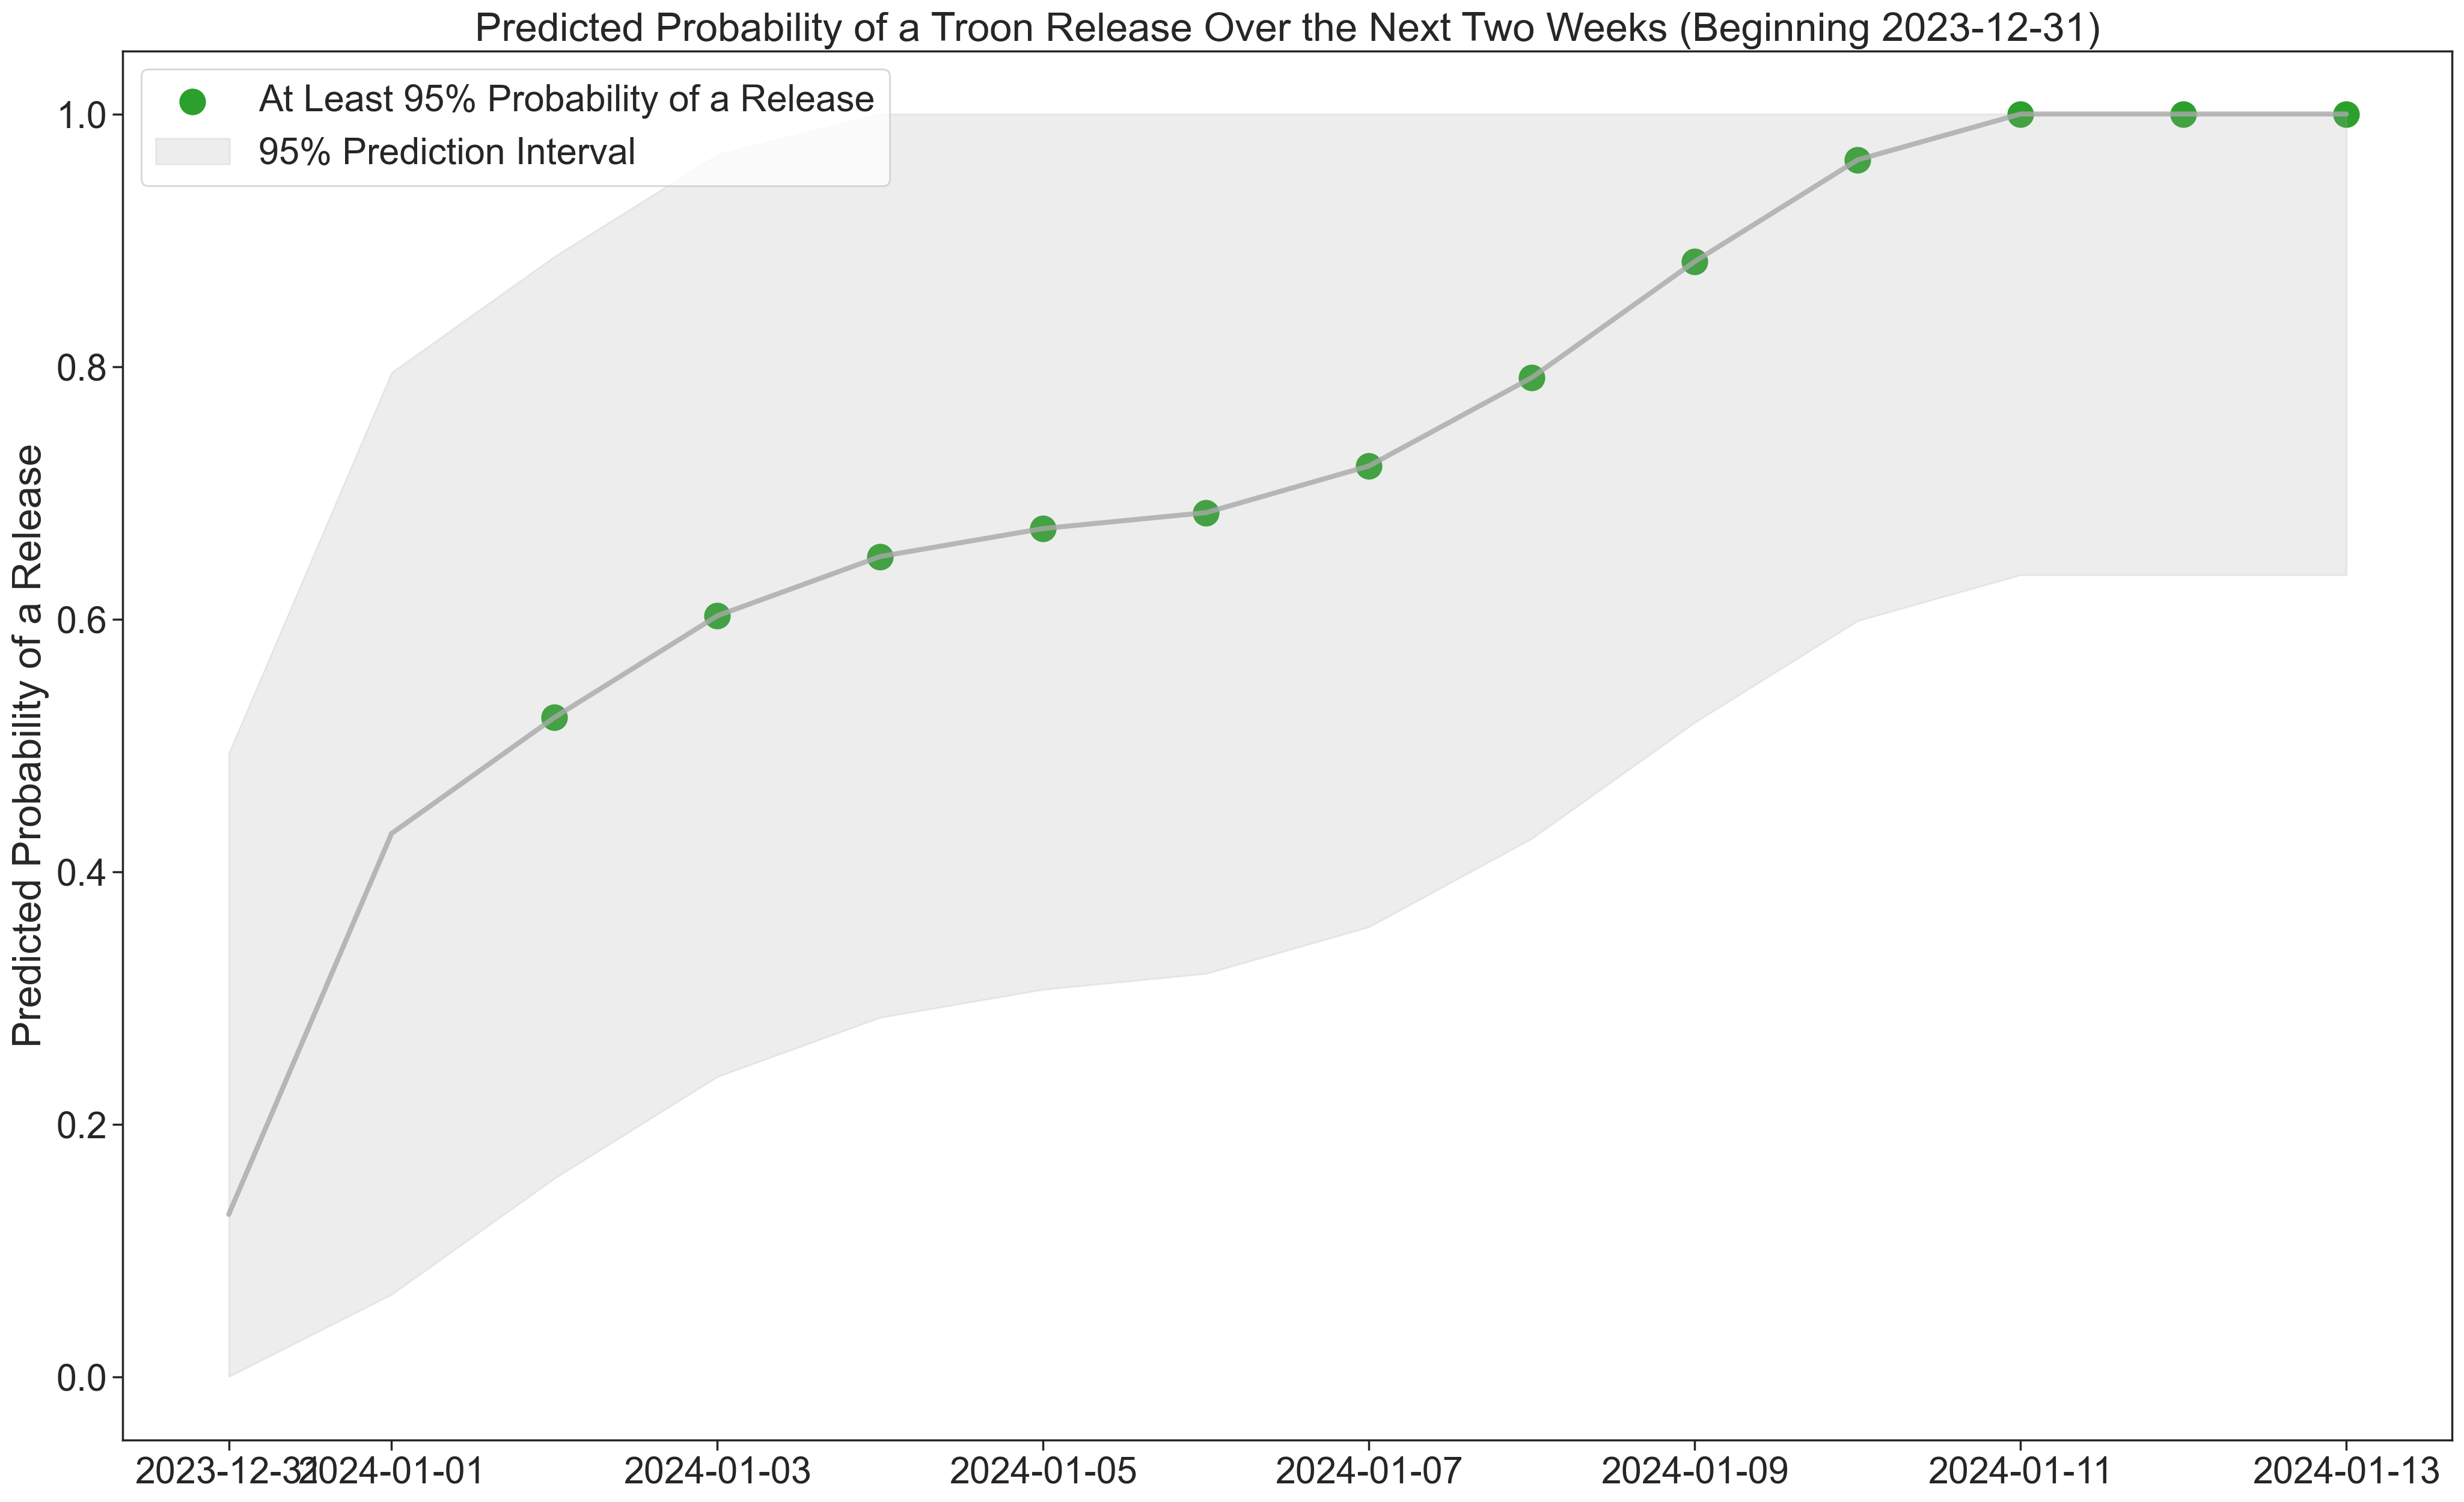

In [73]:
ax = sns.lineplot(data=next_month[:14], x="index", y="predicted_prob", linewidth=3, color="darkgrey", alpha=0.8)
sns.scatterplot(data=next_month[:14][next_month["predicted_prob"] >= 0.50], x="index", y="predicted_prob",
                s=300, ax=ax, color="tab:green", label="At Least 95% Probability of a Release")

ax.fill_between(x=next_month[:14]["index"],
                y1=next_month[:14]["predicted_min"],
                y2=next_month[:14]["predicted_max"],
                label="95% Prediction Interval",
                alpha=0.2,
                color="darkgrey")

ax.set_xlabel(None)
ax.set_ylabel("Predicted Probability of a Release")
ax.set_title("Predicted Probability of a Troon Release Over the Next Two Weeks (Beginning {})".format(
    next_month["index"].iloc[0].date()))
ax.legend()
plt.show()